In [584]:
dppy.__file__

'/Users/vl238/miniconda3/envs/detpop/lib/python3.7/site-packages/dppy/__init__.py'

In [266]:
from collections import Counter
import mirdata
import numpy as np
import operator

msdb_instrument_dict = {
    "0": "clarinet",
    "1": "guitar",
    "2": "voice",
    "3": "flute",
    "4": "piano",
    "5": "saxophone",
    "6": "trumpet",
    "7": "violin"
}

data_home = '/Users/vl238/'
msdb = mirdata.medley_solos_db.load()
n_instruments = 8
n_samples_per_song = 8
n_songs_per_instrument = 8
instrument_song_ids = []

# Select 8 songs per instrument
for instrument_id in range(n_instruments):
    msdb_instrument = {
        key: msdb[key]
        for key in msdb.keys()
        if msdb[key].instrument_id == instrument_id
    }
    msdb_counter = Counter(msdb_instrument[key].song_id for key in msdb_instrument)
    sorted_pairs = sorted(msdb_counter.items(), key=operator.itemgetter(1), reverse=True)
    instrument_song_ids.append(np.array([
        sorted_pairs[song_id][0] for song_id in range(n_songs_per_instrument)]))
    
instrument_song_ids = np.stack(instrument_song_ids)
msdb10k = {key:msdb[key] for key in msdb.keys() if msdb[key].song_id in instrument_song_ids.ravel()}

# Select 8 samples per song
msdb512_keys = []
for instrument_id in range(n_instruments):
    for song_id_id in range(n_songs_per_instrument):
            msdb_song = {
                key: msdb10k[key] for key in msdb10k.keys()
                if msdb10k[key].instrument_id == instrument_id
                and msdb10k[key].song_id == instrument_song_ids[instrument_id, song_id_id]
            }
            song_keys = sorted(list(msdb_song.keys()))[:n_samples_per_song]
            msdb512_keys += song_keys
msdb512 = {key: msdb10k[key] for key in msdb10k.keys() if key in msdb512_keys}

In [2]:
import kymatio
import numpy
import scipy
import torch
import tqdm

input_length = 65536
n_scattering_scales = 14

scattering_transform = kymatio.Scattering1D(J=n_scattering_scales, shape=(input_length,))
hann_window = scipy.signal.hann(input_length, sym=False)

X_list = []
x
for msdb_key in tqdm.tqdm(msdb512_keys):
    waveform, sample_rate = msdb512[msdb_key].audio
    windowed_waveform = hann_window * waveform
    normalized_waveform = waveform / np.linalg.norm(waveform)
    input_tensor = torch.Tensor(normalized_waveform)
    scattering_matrix = scattering_transform(input_tensor)
    n_frames = scattering_matrix.shape[1]
    scattering_matrix = scattering_matrix[:, (n_frames//4):(-n_frames//4)]
    scattering_vector = np.sum(
        scattering_matrix.numpy(), axis=1)
    X_list.append(scattering_vector)

100%|██████████| 512/512 [01:36<00:00,  5.29it/s]


In [468]:
X_matrix = np.maximum(np.finfo(np.float32).eps, np.stack(X_list))
X_median = np.median(X_matrix, axis=0)
#X = np.log1p(1e3 * X_matrix / X_median[np.newaxis, :])
#X = X_matrix / np.linalg.norm(X_matrix, axis=1)[:, np.newaxis]

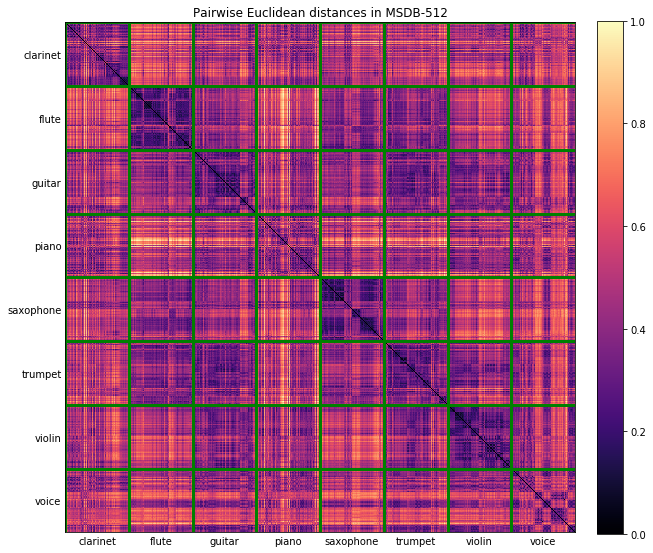

In [471]:
import sklearn

msdb_instrument_dict = {
    "0": "clarinet",
    "1": "guitar",
    "2": "voice",
    "3": "flute",
    "4": "piano",
    "5": "saxophone",
    "6": "trumpet",
    "7": "violin"
}

msdb_instrument_list = [pair[1] for pair in 
    sorted(msdb_instrument_dict.items(), key=operator.itemgetter(1))]

D_euc = sklearn.metrics.pairwise.euclidean_distances(X)
D_euc = D_euc / np.max(D_euc)

plt.figure(figsize=(10, 10))
plt.imshow(D_euc, cmap='magma')
plt.xlim(0, 512)
plt.ylim(0, 512)
plt.clim(0.0, 1.0)
plt.xticks(range(32, 512, 64))
plt.yticks(range(32, 512, 64))
plt.gca().set_xticklabels(msdb_instrument_list)
plt.gca().set_yticklabels(msdb_instrument_list)
plt.gca().invert_yaxis()
plt.gca().tick_params(
    axis=u'both', which=u'both',length=0)
plt.title('Pairwise Euclidean distances in MSDB-512')
plt.colorbar(fraction=0.046, pad=0.04)

for row_id in range(0, 512, 64):
    plt.plot([row_id, row_id], [0, 512], color='g', linewidth=3)
    plt.plot([0, 512], [row_id, row_id], color='g', linewidth=3)

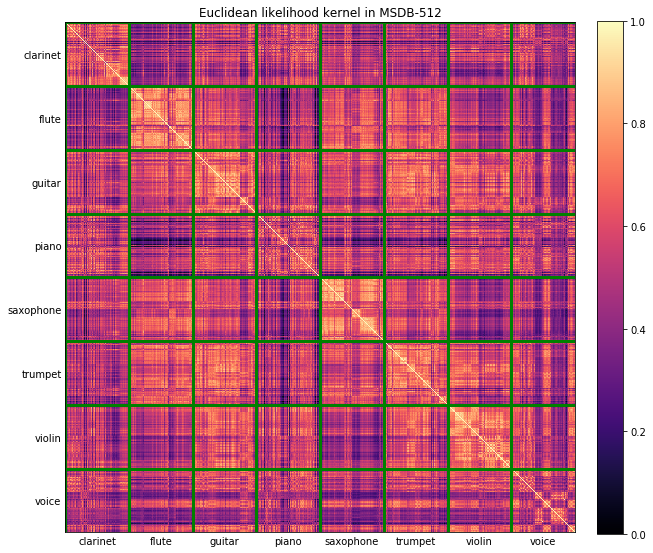

In [473]:
L_euc = 1 - D_euc

plt.figure(figsize=(10, 10))
plt.imshow(L_euc, cmap='magma')
plt.xlim(0, 512)
plt.ylim(0, 512)
plt.clim(0, 1)
plt.xticks(range(32, 512, 64))
plt.yticks(range(32, 512, 64))
plt.gca().set_xticklabels(msdb_instrument_list)
plt.gca().set_yticklabels(msdb_instrument_list)
plt.gca().invert_yaxis()
plt.gca().tick_params(
    axis=u'both', which=u'both',length=0)
plt.title('Euclidean likelihood kernel in MSDB-512')
plt.colorbar(fraction=0.046, pad=0.04)

for row_id in range(0, 512, 64):
    plt.plot([row_id, row_id], [0, 512], color='g', linewidth=3)
    plt.plot([0, 512], [row_id, row_id], color='g', linewidth=3)

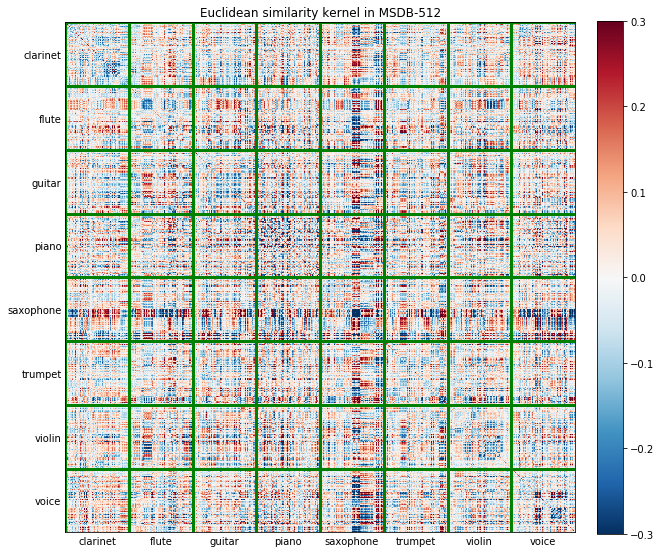

In [562]:


K_euc = np.dot(
    L_euc,
    np.linalg.inv(np.eye(L_euc.shape[0]) - L_euc))

plt.figure(figsize=(10, 10))
plt.imshow(K_euc, cmap='RdBu_r')
plt.xlim(0, 512)
plt.ylim(0, 512)
plt.clim(-0.3, 0.3)
plt.xticks(range(32, 512, 64))
plt.yticks(range(32, 512, 64))
plt.gca().set_xticklabels(msdb_instrument_list)
plt.gca().set_yticklabels(msdb_instrument_list)
plt.gca().invert_yaxis()
plt.gca().tick_params(
    axis=u'both', which=u'both',length=0)
plt.title('Euclidean similarity kernel in MSDB-512')
plt.colorbar(fraction=0.046, pad=0.04)

for row_id in range(0, 512, 64):
    plt.plot([row_id, row_id], [0, 512], color='g', linewidth=3)
    plt.plot([0, 512], [row_id, row_id], color='g', linewidth=3)

3

In [611]:
n_trials = 50

detpop_lengths = []
random_lengths = []

for trial_id in tqdm.tqdm(range(n_trials)):
    
    detpop = dppy.finite_dpps.FiniteDPP(kernel_type='likelihood', L=L_euc)
    detpop.sample_exact_k_dpp(32)
    detpop_ids = detpop.list_of_samples[0]

    detpop_song_counter = Counter([
        msdb512[msdb512_keys[detpop_id]].song_id
        for detpop_id in detpop_ids])
    detpop_lengths.append(len(detpop_song_counter))

    random_song_counter = Counter([
        msdb512[msdb512_keys[random_id]].song_id
        for random_id in np.random.choice(range(512), size=32, replace=False)])
    random_lengths.append(len(random_song_counter))
    





  0%|          | 0/50 [00:00<?, ?it/s]



  2%|▏         | 1/50 [00:00<00:10,  4.83it/s]



  4%|▍         | 2/50 [00:00<00:10,  4.64it/s]



  6%|▌         | 3/50 [00:00<00:10,  4.67it/s]



  8%|▊         | 4/50 [00:00<00:09,  4.61it/s]



 10%|█         | 5/50 [00:01<00:09,  4.71it/s]



 12%|█▏        | 6/50 [00:01<00:09,  4.42it/s]



 14%|█▍        | 7/50 [00:01<00:09,  4.62it/s]



 16%|█▌        | 8/50 [00:01<00:09,  4.46it/s]



 18%|█▊        | 9/50 [00:02<00:09,  4.41it/s]



 20%|██        | 10/50 [00:02<00:08,  4.56it/s]



 22%|██▏       | 11/50 [00:02<00:08,  4.68it/s]



 24%|██▍       | 12/50 [00:02<00:08,  4.69it/s]



 26%|██▌       | 13/50 [00:02<00:07,  4.71it/s]



 28%|██▊       | 14/50 [00:03<00:07,  4.87it/s]



 30%|███       | 15/50 [00:03<00:07,  4.91it/s]



 32%|███▏      | 16/50 [00:03<00:07,  4.79it/s]



 34%|███▍      | 17/50 [00:03<00:07,  4.50it/s]



 36%|███▌      | 18/50 [00:03<00:06,  4.62it/s]



 38%|███▊      | 19/50 [00:04<00:06,  4.72it/

([<matplotlib.patches.Wedge at 0x15190e250>,
 [Text(-0.20611945413751356, 1.080515974257694, 'detpop has more songs: 56%'),
  Text(-0.1378665283110825, -1.0913261750601648, 'random has more songs: 34%'),
  Text(1.0461621822461364, -0.3399186497354948, 'tie: 10%')])

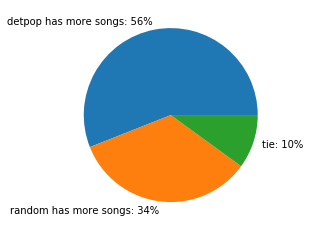

In [613]:
sign_counter = Counter(np.sign(np.array(random_lengths) - np.array(detpop_lengths)))
plt.pie([
    sign_counter[-1], sign_counter[1], sign_counter[0]],
    labels=[
        'detpop has more songs: {:2.0f}%'.format(100*sign_counter[-1]/sum(sign_counter.values())),
        'random has more songs: {:2.0f}%'.format(100*sign_counter[1]/sum(sign_counter.values())),
        'tie: {:2.0f}%'.format(100*sign_counter[0]/sum(sign_counter.values()))])